In [ ]:
import os
import base64
from PIL import Image
from io import BytesIO
from IPython.display import display

from byaldi import RAGMultiModalModel

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

In [ ]:
with open('hf_key.txt', 'r') as file:
    hf_key = file.read().strip()

with open("openai_api_key.txt", "r") as file:
    openai_key = file.read().strip()

os.environ["HF_TOKEN"] = hf_key
os.environ["OPENAI_API_KEY"] = openai_key

In [3]:
try:
    RAG = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v1.0", device="mps")
    RAG.index(
        input_path="docs/", # The path to your documents
        index_name="test", # The name you want to give to your index. It'll be saved at `index_root/index_name/`.
        store_collection_with_index=True, # Whether the index should store the base64 encoded documents.
        overwrite=False # Whether to overwrite an index if it already exists. If False, it'll return None and do nothing if `index_root/index_name` exists.
    )
except Exception as e:
    RAG.from_index("test", device="mps")

Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.38s/it]


Indexing file: docs/Colpali.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Index exported to .byaldi/test
Index exported to .byaldi/test


In [19]:
query = "How fast is Colpali's indexing time compared to PDF Parser?"

results = RAG.search(query, k=1)

In [20]:
results

[{'doc_id': 0, 'page_num': 5, 'score': 17.0, 'metadata': {}, 'base64': 'iVBORw0KGgoAAAANSUhEUgAABnYAAAkjCAIAAACzq+aSAAEAAElEQVR4nOzddUAU2/8//kOHgIGoSAiKCogKJgaKDXaLgh1g61W8dmJ3dycqtmJjoKKAioqKikpJSTfs7vz+OL/3+c5nFtaFBfHe+3z8BWdnZ85OnnmdUuI4jgAAAAAAAAAAAEBJKZd3BgAAAAAAAAAAAP7ZEGIDAAAAAAAAAABQCEJsAAAAAAAAAAAACkGIDQAAAAAAAAAAQCEIsQEAAAAAAAAAACgEITYAAAAAAAAAAACFIMQGAAAAAAAAAACgEITYAAAAAAAAAAAAFIIQGwAAAAAAAAAAgEIQYgMAAAAAAAAAAFAIQmwAAAAAAAAAAAAKQYgNAAAAAAAAAABAIQixAQAAAAAAAAAAKAQhNgAAAAAAAAAAAIUgxAYAAAAAAAAAAKAQhNgAAAAAAAAAAAAUghAbAAAAAAAAAACAQhBiAwAAAAAAAAAAUAhCbAAAAAAAAAAAAApBiA0AAAAAAAAAAEAhCLEBAAAAAAAAAAAoBCE2AAAAAAAAAAAAhSDEBgAAAAAAAAAAoBCE2AAAAAAAAAAAABSCEBsAAAAAAAAAAIBCEGIDAAAAAAAAAABQCEJsAAAAAAAAAAAACkGIDQAAAAAAAAAAQCEIsQEAAAAAAAAAACgEITYAAAAAAAAAAACFIMQGAAAAAAAAAACgEITYAAAAAAAAAAAAFIIQGwAAAAAAAAAAgEIQYgMAAAAAAAAAAFAIQmwAAAAAAAAAAAAKQYgNAAAAAAAAAABAIQixAQAAAAAAAAAAKAQhNgAAAAAAAAAAAIUgxAYAAAAAAAAAAKAQhNgAAAAAAAAAAAAUghAbAAAAAAAAAACAQhBiAwAAAAAAAAAAUAhCbAAAAAAAAAAAAApBiA0AAAAAAAAAAEAh

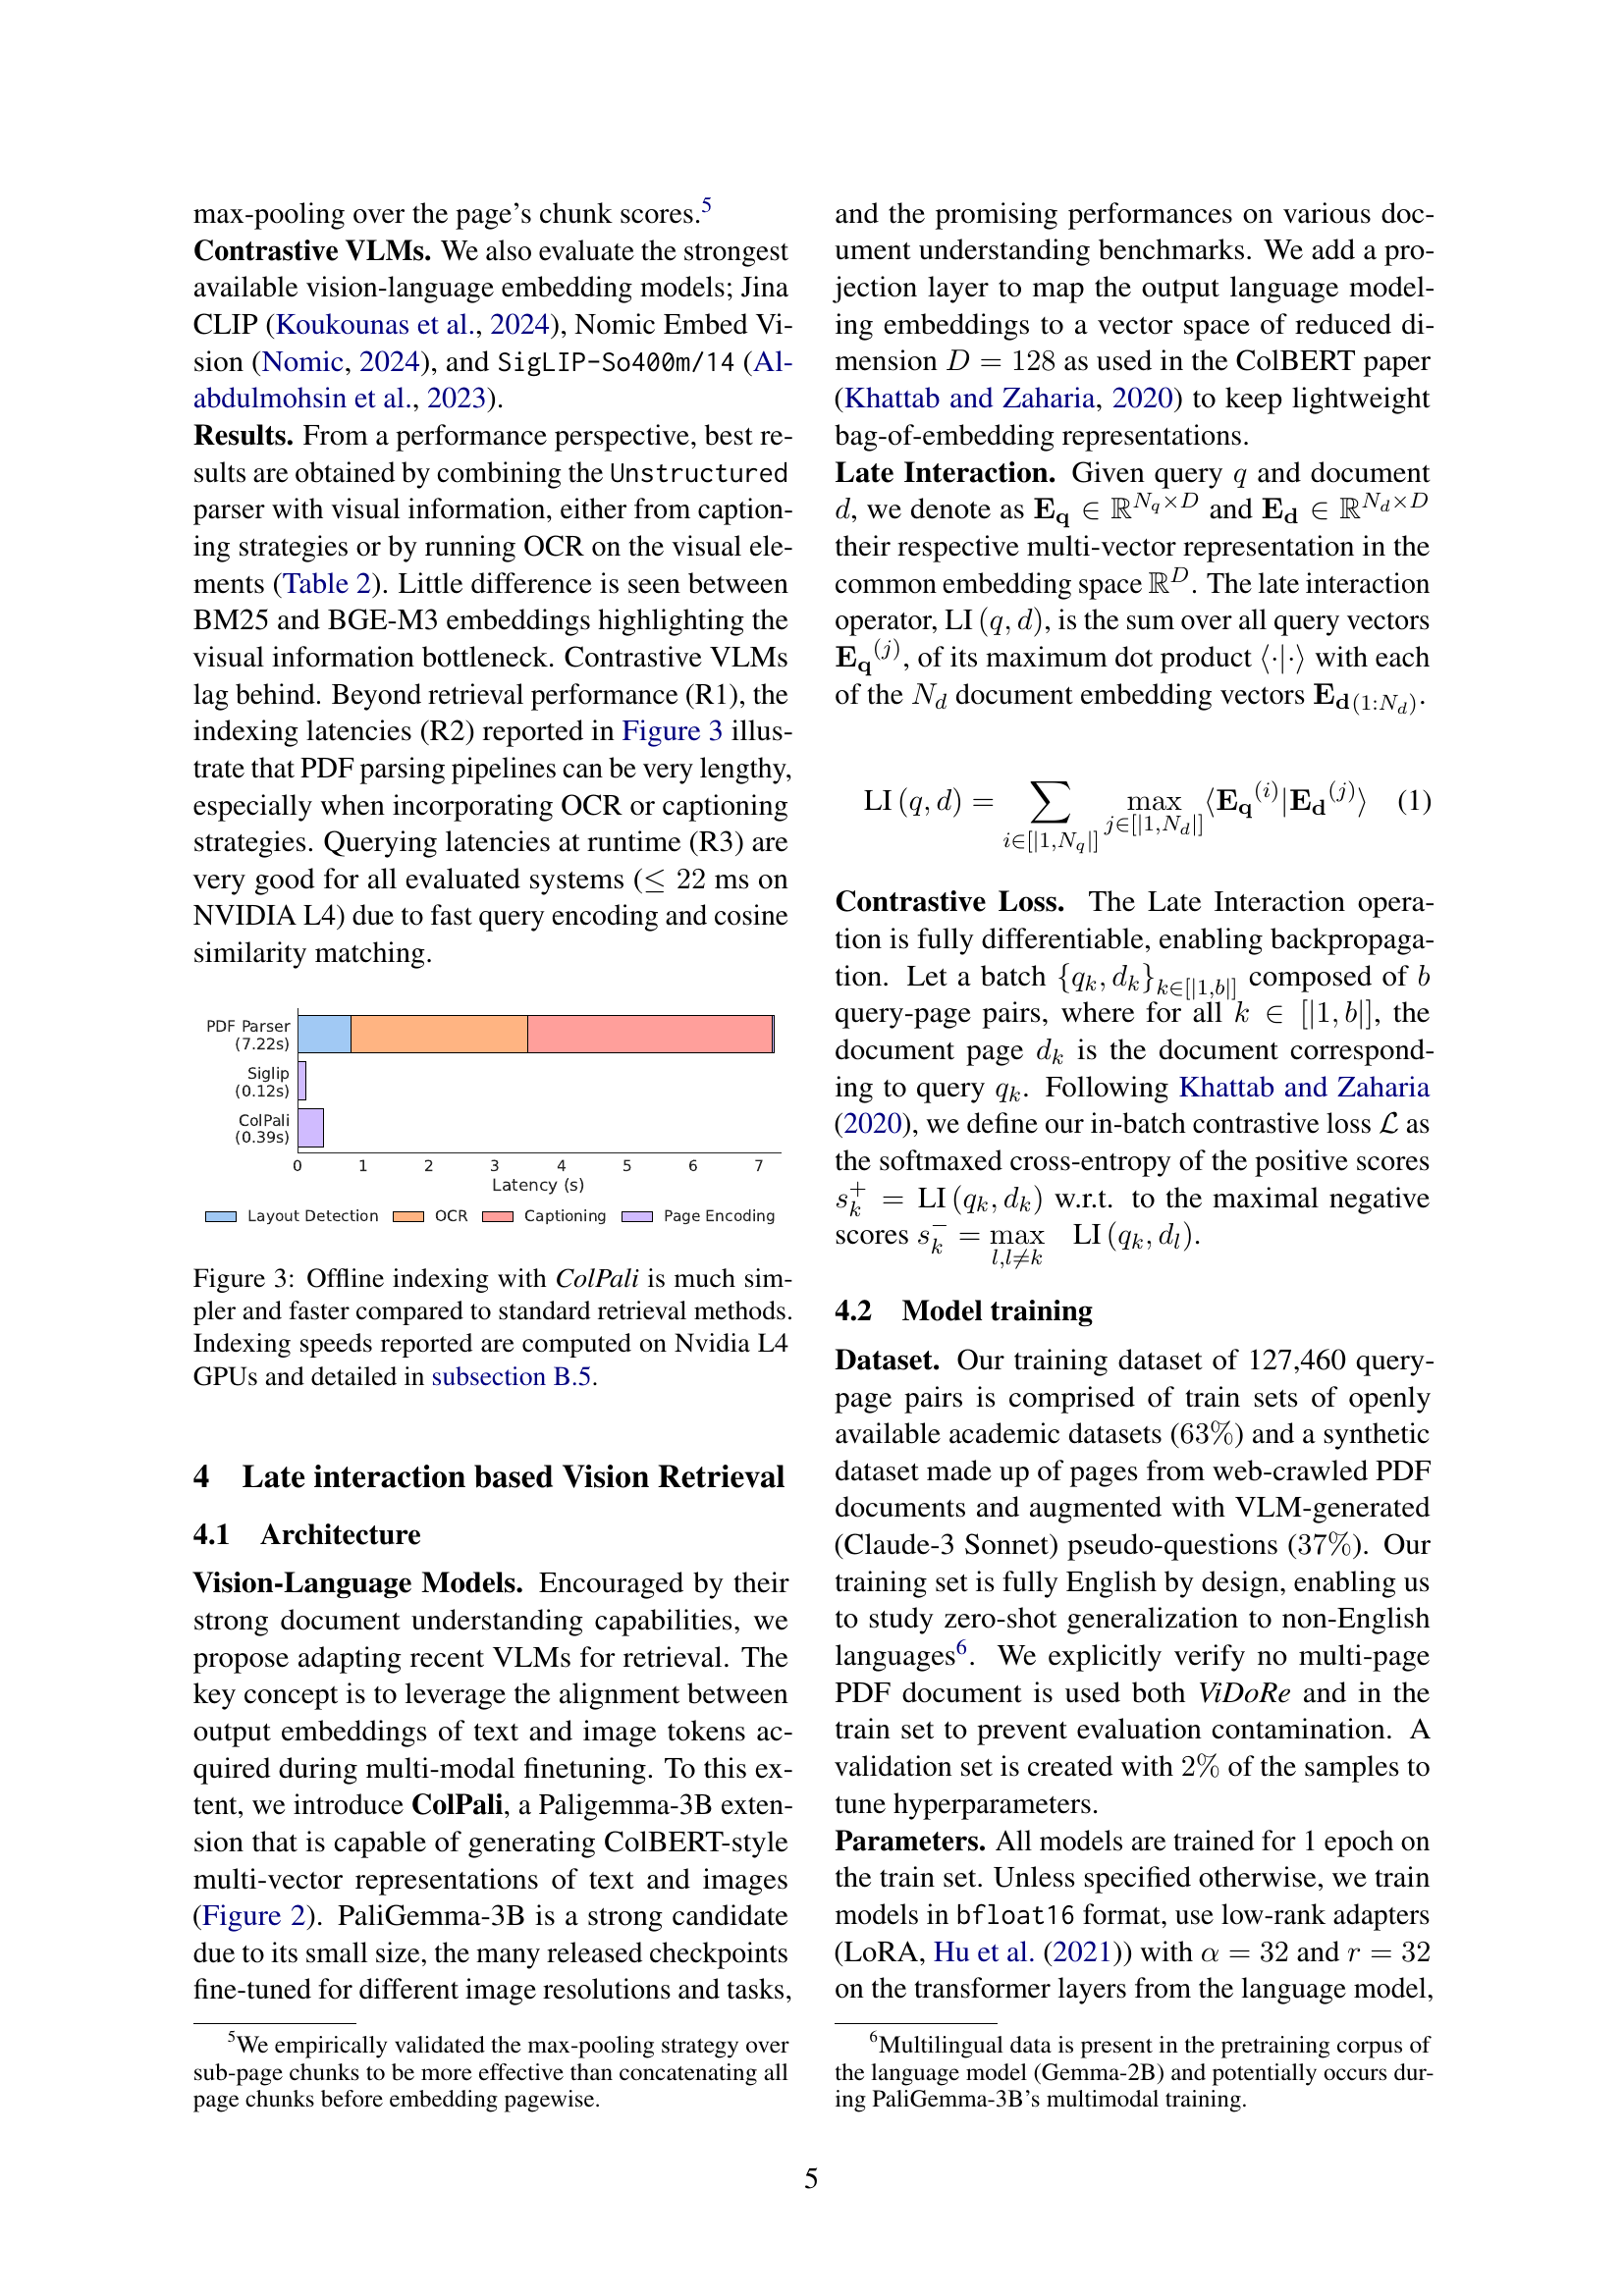

In [21]:
# Decode the base64 string
image_data = base64.b64decode(results[0]['base64'])

# Convert the bytes to an image
image = Image.open(BytesIO(image_data))

# Display the image in the notebook
display(image)

In [22]:
model = ChatOpenAI(model="gpt-4o")

In [23]:
message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/pdf;base64,{results[0]['base64']}"},
        },
    ],
)

response = model.invoke([message])

In [24]:
response.content

"Colpali's indexing time is significantly faster than PDF Parser. According to Figure 3 in the document, Colpali takes approximately 0.39 seconds, whereas PDF Parser takes about 7.12 seconds."